### Can We Predict NBA Playoff Teams from Regular Season Statistics?

### Introduction

Every NBA season, teams play 82 regular-season games in hopes of earning a spot in the playoffs. But what determines whether a team qualifies for the postseason? Is it offensive abilities? Lockdown defense? Or something more discrete like pace of play or turnover efficiency?

In this project, we aim to explore whether **a team's regular-season performance stats can accurately predict playoff qualification**. Using historical data from NBA seasons between 2000 and 2023, we'll cover:

- Which stats are most associated with playoff success?
- Can we build a model that predicts whether a team will make the playoffs?
- How well do naturally formed statistical "clusters" align with actual playoff outcomes?

This project is built using logic-based modeling concepts covered in class — particularly logistic regression, correlation analysis, and clustering via K-Means and PCA.

### Data Overview

The dataset includes season-level summary statistics for each NBA team from 2000 through 2023, one row per team per season. The data was sourced from [Basketball Reference](https://www.basketball-reference.com/) and downloaded from Kaggle. It includes only regular season statistics (not playoff performance).

Playoff status is extracted from the original dataset by checking if a team name contains an asterisk `*`, which signifies a playoff team.

Our goal is to use these stats to predict the `Playoff` label (1 = made playoffs, 0 = did not) without relying on external projections or betting lines. This simulates a scenario where we evaluate playoff likelihood purely from observed performance.

#### Data Details

The table below includes all of the columns included in the data set along with a brief description. Columns like **NA**, **NA.1**, and **NA.2** were present in the raw data but appear to be empty placeholders and will be removed in the cleaning step. 


| Column Name     | Description                                                                  |
|------------------|-----------------------------------------------------------------------------|
| **Rk**           | Rank of the team that season (based on performance)                         |
| **Team**         | Team name                                                                   |
| **Age**          | Average age of players on the roster                                        |
| **W** / **L**    | Wins and Losses during the regular season                                   |
| **PW** / **PL**  | Projected Wins and Losses (e.g. from preseason models or betting lines)     |
| **MOV**          | Margin of Victory per game                                                  |
| **SOS**          | Strength of Schedule                                                        |
| **SRS**          | Simple Rating System (MOV adjusted for SOS)                                 |
| **ORtg**         | Offensive Rating – points scored per 100 possessions                        |
| **DRtg**         | Defensive Rating – points allowed per 100 possessions                       |
| **NRtg**         | Net Rating = ORtg - DRtg (overall team strength)                            |
| **Pace**         | Possessions per 48 minutes (team tempo)                                     |
| **FTr**          | Free Throw Rate (FT attempts per FG attempt)                                |
| **3PAr**         | 3-Point Attempt Rate (3PA / FGA)                                            |
| **TS%**          | True Shooting % (adjusted for FG, 3P, FT efficiency)                        |
| **eFG%**         | Effective FG % on offense                                                   |
| **TOV%**         | Turnover % on offense                                                       |
| **ORB%**         | Offensive Rebound Rate                                                      |
| **FT/FGA**       | Free Throws per Field Goal Attempt (offense)                                |
| **eFG%.1**       | Opponent Effective FG % (defensive stat)                                    |
| **TOV%.1**       | Turnover % forced on defense                                                |
| **DRB%**         | Defensive Rebound Rate                                                      |
| **FT/FGA.1**     | Opponent Free Throws per Field Goal Attempt (defensive FT rate)             |
| **Arena**        | Team’s home arena                                                           |
| **Attend.**      | Total attendance at home games                                              |
| **Attend./G**    | Average attendance per home game                                            |
| **Year**         | Season year (column renamed from "2000" in header)                          |


> **Note:**  
> While the dataset includes **PW** (Projected Wins) and **PL** (Projected Losses), these values were **not used in the prediction model**.
> They are included only for reference and potential future analysis.  
> Including projected outcomes as inputs when trying to predict actual playoff appearance would introduce data leakage, as they may reflect expectations or factors not strictly tied to on-court performance.

> | Column Name            | Description                                                                 |
> |------------------------|-----------------------------------------------------------------------------|
> | **PW**                 | Projected Wins (model-based preseason or statistical projection)            |
> | **PL**                 | Projected Losses (model-based preseason or statistical projection)          |

### Step 1: Data Cleaning

Before we can analyze or model the data, we need to ensure it’s clean, consistent, and usable. The raw dataset is rich with team-level NBA stats, but it requires structural cleanup and clarification of several ambiguous columns.


#### Dataset Structure

The dataset includes regular season stats for all NBA teams from 2000–2023. However:
- The first row contains some unclear / offset column labels.
- The second row contains the true column headers, but includes duplicate names like **eFG%** and **TOV%**, which appear for both offense and defense.
- There are also placeholder columns such as NA which need to be removed.


#### Strategy

1. Import necessary libraries for data handling and visualization: pandas, numpy, matplotlib.pyplot, and seaborn.

2. Load the dataset using the second row as the actual header (header=1).

3. Remove repeated header rows embedded in the data (where **'Rk'** == **'Rk'**).

4. Drop placeholder or meaningless columns, such as NA.

5. Clean team names by removing asterisks `*`, which indicate playoff teams. These will be used later to generate the `Playoff` label.

6. Rename ambiguous columns to clarify whether they refer to offense or defense (see table below for full details).

7. Remove commas from string-based numeric columns like `Attend` and `Attend_per_Game`, then convert them to numeric.

8. Calculate `Attend_per_Game` for seasons like 2000 where it’s missing using:  `Attend / (W+L)`

9. Convert all remaining numeric-looking columns to numeric values for clean modeling.

10. Create a `WinPct` (win percentage) column as a high-level indicator of team success, using the formula: `W / (W + L)`.

11. Drop any rows missing `WinPct`, and reset the index for a clean DataFrame.



#### Renamed Columns for Clarity

| Original Column Name | Renamed To         | Description                                           |
|----------------------|--------------------|-------------------------------------------------------|
| `eFG%`               | `eFG_Offense%`     | Effective Field Goal % on offense                     |
| `TOV%`               | `TOV_Offense%`     | Turnover % on offense                                 |
| `FT/FGA`             | `FT/FGA_Offense`   | Free Throws per Field Goal Attempt on offense         |
| `eFG%.1`             | `eFG%_Defense`     | Effective FG % allowed (defensive stat)               |
| `TOV%.1`             | `TOV%_Defense`     | Turnover % forced on defense                          |
| `FT/FGA.1`           | `FT/FGA_Defense`   | Free Throws per Field Goal Attempt allowed (defense)  |
| `Attend.`            | `Attend`           | Total home game attendance                            |
| `Attend./G`          | `Attend_per_Game`  | Average attendance per home game                      |
| `2000`               | `Year`             | Season year                                           |


### Step 1: Data Cleaning --- Code

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [21]:
# Load the dataset using the second row as the actual header
df = pd.read_csv("/Users/samanthashuford/Desktop/advanced_stats_total.csv", header=1)

# Remove repeated header rows embedded in the data
df = df[df['Rk'] != 'Rk'].copy()

# Define renaming for ambiguous or duplicated column names
rename_columns = {
    'eFG%': 'eFG_Offense%',
    'TOV%': 'TOV_Offense%',
    'FT/FGA': 'FT/FGA_Offense',
    'eFG%.1': 'eFG%_Defense',
    'TOV%.1': 'TOV%_Defense',
    'FT/FGA.1': 'FT/FGA_Defense',
    'Attend.': 'Attend',
    'Attend./G': 'Attend_per_Game',
    '2000': 'Year'
}

# Apply column renaming
df.rename(columns=rename_columns, inplace=True)

# Drop placeholder or non-useful columns
drop_cols = ['1', 'NA', 'NA.1', 'NA.2', '...29', '...30', '...31']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

# Clean up team names (remove asterisk indicating playoff teams)
df['Team'] = df['Team'].str.replace('*', '', regex=False).str.strip()

# Ensure W and L are numeric
df['W'] = pd.to_numeric(df['W'], errors='coerce')
df['L'] = pd.to_numeric(df['L'], errors='coerce')

# Remove commas from attendance columns and convert to numeric
if 'Attend' in df.columns:
    df['Attend'] = df['Attend'].str.replace(',', '', regex=False)
    df['Attend'] = pd.to_numeric(df['Attend'], errors='coerce')

if 'Attend_per_Game' in df.columns:
    df['Attend_per_Game'] = df['Attend_per_Game'].str.replace(',', '', regex=False)
    df['Attend_per_Game'] = pd.to_numeric(df['Attend_per_Game'], errors='coerce')

# Calculate missing Attend_per_Game values
if 'Attend' in df.columns and 'Attend_per_Game' in df.columns:
    missing_apg = df['Attend_per_Game'].isna() & df['Attend'].notna()
    df.loc[missing_apg, 'Attend_per_Game'] = df.loc[missing_apg, 'Attend'] / (df.loc[missing_apg, 'W'] + df.loc[missing_apg, 'L'])

# Round the calculate Attend_per_Game to zero decimals
df['Attend_per_Game'] = df['Attend_per_Game'].round()

# Convert all other numeric-looking columns (except team and arena)
for col in df.columns:
    if col not in ['Team', 'Arena', 'Attend', 'Attend_per_Game']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create a win percentage column
df['WinPct'] = df['W'] / (df['W'] + df['L'])

# Drop rows where WinPct is missing
df.dropna(subset=['WinPct'], inplace=True)

# Reset index after cleaning
df.reset_index(drop=True, inplace=True)

# Preview cleaned data
df.head()


,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,FT/FGA_Offense,eFG%_Defense,TOV%_Defense,DRB%,FT/FGA_Defense,Arena,Attend,Attend_per_Game,Year,WinPct
0,1.0,Los Angeles Lakers,29.2,67.0,15.0,64,18,8.55,-0.14,8.41,...,0.241,0.443,13.4,73.1,0.222,STAPLES Center,771420.0,9408.0,2000,0.817073
1,2.0,Portland Trail Blazers,29.6,59.0,23.0,59,23,6.40,-0.04,6.36,...,0.240,0.461,13.8,72.4,0.217,Rose Garden Arena,835078.0,10184.0,2000,0.719512
2,3.0,San Antonio Spurs,30.9,53.0,29.0,58,24,5.94,-0.02,5.92,...,0.258,0.451,13.5,73.0,0.188,Alamodome,884450.0,10786.0,2000,0.646341
3,4.0,Phoenix Suns,28.6,53.0,29.0,56,26,5.22,0.02,5.24,...,0.217,0.454,15.7,70.5,0.245,America West Arena,773115.0,9428.0,2000,0.646341
4,5.0,Utah Jazz,31.5,55.0,27.0,54,28,4.46,0.05,4.52,...,0.260,0.477,15.0,73.2,0.256,Delta Center,801268.0,9772.0,2000,0.670732


### Step 2: Adding Playoff Labels

In this step, we add a new column to our cleaned dataset that labels whether a team made the playoffs (`Playoff = 1`) or not (`Playoff = 0`).

#### Strategy

1. Reload the original raw dataset, which still includes the asterisks (`*`) next to team names that made the playoffs. These were removed earlier during cleaning for consistency, but now we’ll use them to generate labels.

2. Create a binary `Playoff` column:
   - If a team name contains an asterisk `*`, it's labeled as `1` (made the playoffs).
   - If not, it’s labeled as `0`.

3. Clean the team name again to match the cleaned version in `df`, ensuring we can safely merge the `Playoff` data back into the main dataset.

4. Merge the `Playoff` label into our cleaned dataset using both `Team` and `Year` as keys.

5. Fill in any missing playoff labels as `0`, in case of a mismatch or incomplete data.

This step gives us the outcome variable we’ll use for classification modeling and clustering analysis in later sections.


### Step 2: Adding Playoff Labels --- Code

In [22]:
# Load the original dataset again (uncleaned), starting from the second row
# This version still has asterisks (*) indicating playoff teams
raw_df = pd.read_csv("/Users/samanthashuford/Desktop/advanced_stats_total.csv").iloc[1:].copy()

# Create a binary column 'Playoff' based on presence of asterisk in the team name
# Teams with '*' made the playoffs → 1; otherwise → 0
raw_df['Playoff'] = raw_df['Team'].str.contains('\\*', regex=True).astype(int)

# Remove the asterisk from team names so they match our cleaned dataset
raw_df['Team'] = raw_df['Team'].str.replace('*', '', regex=False).str.strip()

# Merge the playoff flag back into the cleaned dataframe using 'Team' and 'Year' as keys
df = df.merge(raw_df[['Team', 'Year', 'Playoff']], on=['Team', 'Year'], how='left')

# Fill any missing values in 'Playoff' with 0 (if a team didn't match for some reason)
df['Playoff'] = df['Playoff'].fillna(0).astype(int)

# Observe the data
df.head()

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,eFG%_Defense,TOV%_Defense,DRB%,FT/FGA_Defense,Arena,Attend,Attend_per_Game,Year,WinPct,Playoff
0,1.0,Los Angeles Lakers,29.2,67.0,15.0,64,18,8.55,-0.14,8.41,...,0.443,13.4,73.1,0.222,STAPLES Center,771420.0,9408.0,2000,0.817073,1
1,2.0,Portland Trail Blazers,29.6,59.0,23.0,59,23,6.40,-0.04,6.36,...,0.461,13.8,72.4,0.217,Rose Garden Arena,835078.0,10184.0,2000,0.719512,1
2,3.0,San Antonio Spurs,30.9,53.0,29.0,58,24,5.94,-0.02,5.92,...,0.451,13.5,73.0,0.188,Alamodome,884450.0,10786.0,2000,0.646341,1
3,4.0,Phoenix Suns,28.6,53.0,29.0,56,26,5.22,0.02,5.24,...,0.454,15.7,70.5,0.245,America West Arena,773115.0,9428.0,2000,0.646341,1
4,5.0,Utah Jazz,31.5,55.0,27.0,54,28,4.46,0.05,4.52,...,0.477,15.0,73.2,0.256,Delta Center,801268.0,9772.0,2000,0.670732,1


### Step 3: Exploratory Data Analysis

In this step, we begin to explore the data to identify patterns, relationships, and potential predictors of playoff success.

#### Strategy

1. **Correlation Heatmap**  
   We begin by generating a correlation heatmap of all numeric features (excluding outcome variables like `Playoff`, `PW`, `PL`, and `Rk`).  
   This helps us:
   - Spot multicollinearity (strongly correlated features)  
   - See how metrics move together  
   - Identify redundancies or opportunities for dimensionality reduction

>   **Heatmap Color Legend**:
   - **Dark Blue** = strong positive correlation (when one feature increases, the other tends to increase)  
   - **Dark Red** = strong negative correlation (when one feature increases, the other tends to decrease)  
   - **Light Colors / White** = weak or no correlation  

2. **Bar Chart: Features Correlated with Playoff Status**  
   Next, we focus in on our target outcome — making the playoffs — and examine how each numeric feature correlates with `Playoff`.  
   We visualize the **top 10 positive** and **top 10 negative** correlations in a horizontal bar chart.

>   **Bar Chart Color Legend**:
   - **Positive correlation** = higher values of the feature are associated with playoff teams  
   - **Negative correlation** = higher values are associated with non-playoff teams  

   This gives us a starting point for identifying which features may be worth including in future models.

### Step 3: Correlation Heatmap --- Code

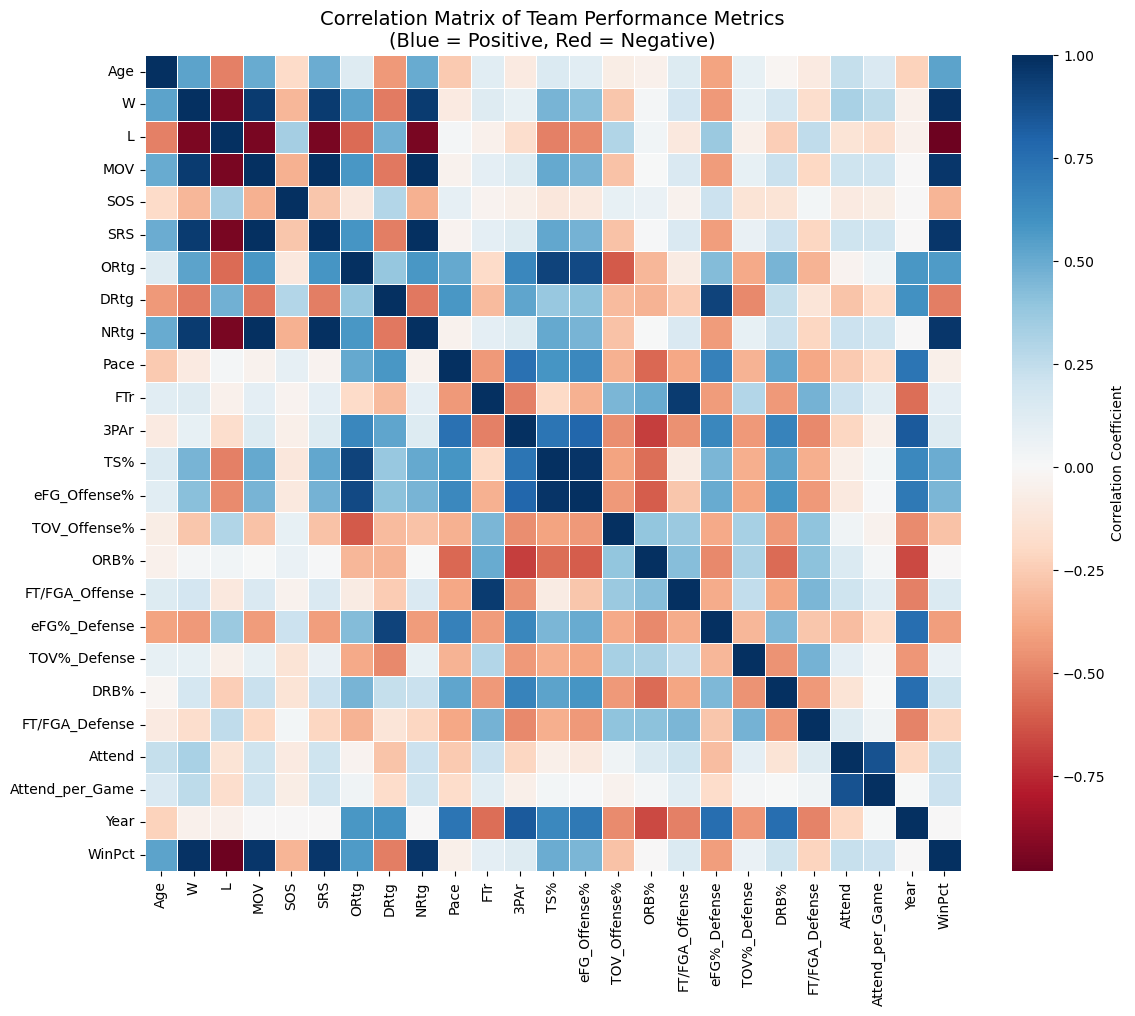

In [23]:
# List of columns to exclude from the correlation matrix
exclude_cols = ['Playoff', 'PW', 'PL', 'Rk']

# Create a subset of the dataframe for correlation
heatmap_df = df.drop(columns=[col for col in exclude_cols if col in df.columns])

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_df.corr(numeric_only=True), 
    cmap='RdBu',              # Red = negative, Blue = positive
    annot=False,
    center=0,                 # Ensure white is centered around 0 correlation
    square=True,              # Keep heatmap grid square
    linewidths=0.5,           # Add grid lines for better readability
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title("Correlation Matrix of Team Performance Metrics\n(Blue = Positive, Red = Negative)", fontsize=14)
plt.tight_layout()
plt.show()

### Step 3 - Bar Chart: Features Correlated with Playoff Status --- Code

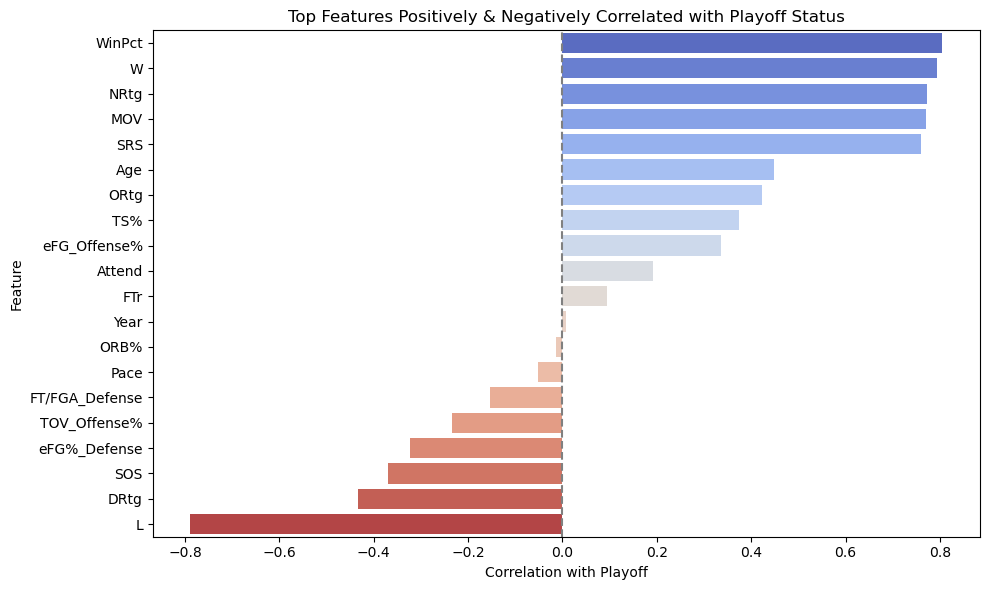

In [24]:
# Calculate correlation with 'Playoff', excluding itself, Rk, PW, PL
playoff_corr = df.corr(numeric_only=True)['Playoff'].drop(labels=['Playoff', 'PW', 'PL', 'Rk'], errors='ignore')

# Sort values by strength of correlation
playoff_corr = playoff_corr.sort_values(ascending=False)

# Get top 10 positive and bottom 10 negative correlations
top_corr = playoff_corr.head(10)
bottom_corr = playoff_corr.tail(10)
corr_subset = pd.concat([top_corr, bottom_corr])

# Plot the results as a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_subset.values, y=corr_subset.index,hue=corr_subset.index, legend=False, palette='coolwarm')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Top Features Positively & Negatively Correlated with Playoff Status")
plt.xlabel("Correlation with Playoff")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Step 4: Logistic Regression (3 Methods)

In this section, we’ll build and compare three versions of logistic regression to predict whether an NBA team makes the playoffs based on regular-season statistics.

#### Methods:
1. **From-Scratch (No Training)**  
   We use randomly initialized weights and apply the sigmoid function to get predictions. This acts as a basic baseline for comparison, but doesn't involve any learning.

2. **Gradient Ascent (Manual Training)**  
   Using the gradients of the log-likelihood, we optimize the model parameters over multiple iterations. This mirrors the optimization techniques we learned in class.

3. **Scikit-learn Logistic Regression**  
   This is the standard library implementation. We'll use it as a benchmark to confirm the performance of our manual models.

We'll compare the accuracy of all three approaches. 

In [25]:
# FROM-SCRATCH LOGISTIC REGRESSION (No optimization)

exclude_cols = ['Team', 'Arena', 'W', 'L', 'WinPct', 'Year', 'Playoff', 'PW', 'PL', 'Rk']
X = df.drop(columns=[col for col in exclude_cols if col in df.columns]).dropna()
y = df.loc[X.index, 'Playoff'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Define sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Step 4: Initialize random weights and compute predictions
np.random.seed(0)
weights = np.random.randn(X_scaled.shape[1])
bias = 0

z = np.dot(X_scaled, weights) + bias
probs = sigmoid(z)
preds = (probs >= 0.5).astype(int)

# Step 5: Evaluate
accuracy_scratch = np.mean(preds == y)
print(f"From-Scratch Accuracy (No Training): {accuracy_scratch:.2f}")

From-Scratch Accuracy (No Training): 0.80


In [26]:
# GRADIENT ASCENT LOGISTIC REGRESSION

# Re-initialize weights and bias
np.random.seed(42)
weights = np.random.randn(X_scaled.shape[1])
bias = 0.0

# Training settings
learning_rate = 0.1
n_iterations = 1000
losses = []

for i in range(n_iterations):
    z = np.dot(X_scaled, weights) + bias
    predictions = sigmoid(z)

    errors = y - predictions
    grad_w = np.dot(X_scaled.T, errors)
    grad_b = np.sum(errors)

    weights += learning_rate * grad_w
    bias += learning_rate * grad_b

# Final predictions
final_probs = sigmoid(np.dot(X_scaled, weights) + bias)
final_preds = (final_probs >= 0.5).astype(int)
accuracy_gradient = np.mean(final_preds == y)
print(f"Gradient Ascent Accuracy: {accuracy_gradient:.2f}")

Gradient Ascent Accuracy: 0.93


In [27]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression on full dataset (to match manual approach)
sk_model = LogisticRegression()
sk_model.fit(X_scaled, y)
sk_preds = sk_model.predict(X_scaled)
accuracy_sk = np.mean(sk_preds == y)
print(f"Scikit-learn Logistic Regression Accuracy: {accuracy_sk:.2f}")


Scikit-learn Logistic Regression Accuracy: 0.92


### Evaluating Predictions with a Confusion Matrix (Scikit-learn Model)

To better understand how our logistic regression model is performing — beyond just overall accuracy — we can look at a **confusion matrix**.

This matrix breaks down the model's predictions into four categories:

- **True Positives (TP)**: Teams that made the playoffs and were correctly predicted to do so.
- **False Positives (FP)**: Teams that did **not** make the playoffs but were incorrectly predicted as playoff teams.
- **True Negatives (TN)**: Teams that missed the playoffs and were correctly predicted as non-playoff teams.
- **False Negatives (FN)**: Teams that made the playoffs but were incorrectly predicted to miss them.

This breakdown helps us evaluate:
- Whether the model is more prone to **over-predicting** playoff teams (many FPs)
- Or more **conservative** and likely to miss some actual playoff teams (many FNs)
- How well the model balances precision and recall

This is especially useful in a classification context where **class imbalance** or the **cost of false predictions** might matter.

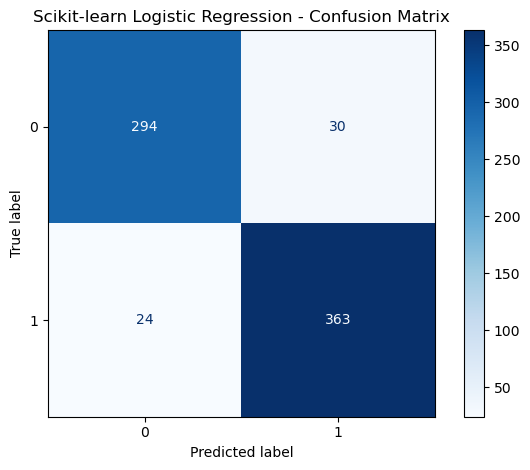

In [28]:
ConfusionMatrixDisplay.from_predictions(y, sk_preds, cmap='Blues')
plt.title("Scikit-learn Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.show()

### Step 4: Logistic Regression Comparisons

In [29]:
# Side-by-side comparison
print("Logistic Regression Accuracy Comparison")
print(f"- From-Scratch (Random Weights):     {accuracy_scratch:.2f}")
print(f"- Manual (Gradient Ascent):          {accuracy_gradient:.2f}")
print(f"- Scikit-learn Logistic Regression:  {accuracy_sk:.2f}")


Logistic Regression Accuracy Comparison
- From-Scratch (Random Weights):     0.80
- Manual (Gradient Ascent):          0.93
- Scikit-learn Logistic Regression:  0.92


### Step 5: Feature Importance (Logistic Regression Cont.)

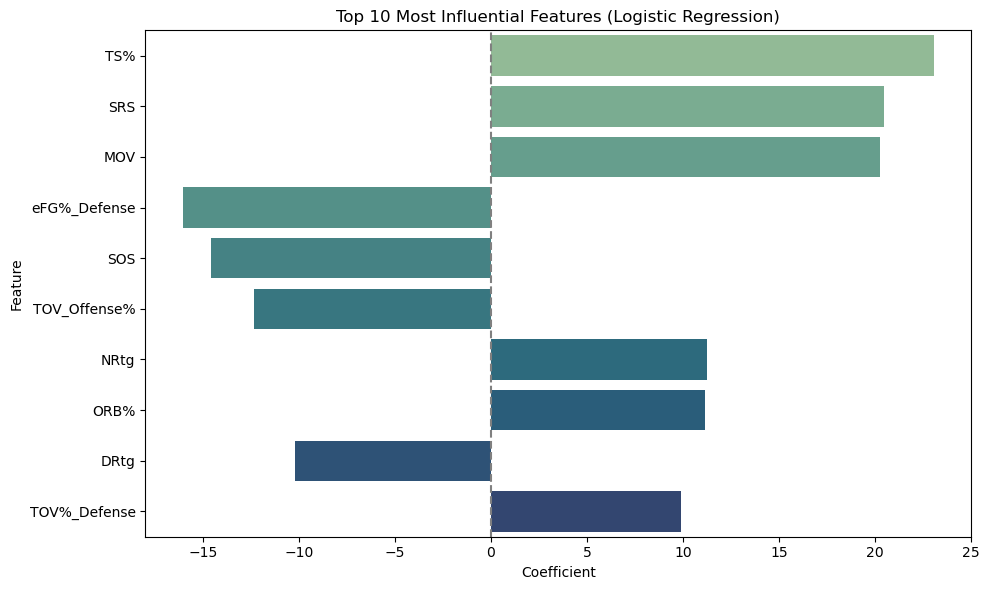

In [30]:
# Confirm dimensions match
assert len(X.columns) == len(weights), "Mismatch between features and weights!"

# Create DataFrame for coefficients from model
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': weights
})

# Sort by absolute value
coef_df['AbsCoef'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values('AbsCoef', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features,
    x='Coefficient',
    y='Feature',
    palette='crest',
    hue='Feature',
    legend=False
)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Top 10 Most Influential Features (Logistic Regression)")
plt.tight_layout()
plt.show()

### Step 6: Clustering with K-Means and PCA

In this step, we use unsupervised learning to explore whether NBA teams naturally form groups based on regular-season performance statistics — without using any label like "Playoff" during training.

#### Strategy
1. **K-Means Clustering**:
   - We apply K-Means clustering with `k=2` to group teams into two clusters.
   - The algorithm assigns teams based only on similarity in features.

2. **PCA for Visualization**:
   - To make clusters visually interpretable, we use Principal Component Analysis (PCA) to reduce the dataset to two dimensions.
   - This allows us to create a 2D scatter plot showing how teams are distributed.

3. **Labeling the Clusters**:
   - We match each cluster to its dominant class (Playoff or Non-Playoff).
   - This helps interpret whether a cluster mostly represents playoff-caliber teams.

4. **Evaluation**:
   - We compare the clusters to actual playoff outcomes to see if K-Means naturally discovers a meaningful grouping.


### Step 6: Clustering with K-Means and PCA --- Code

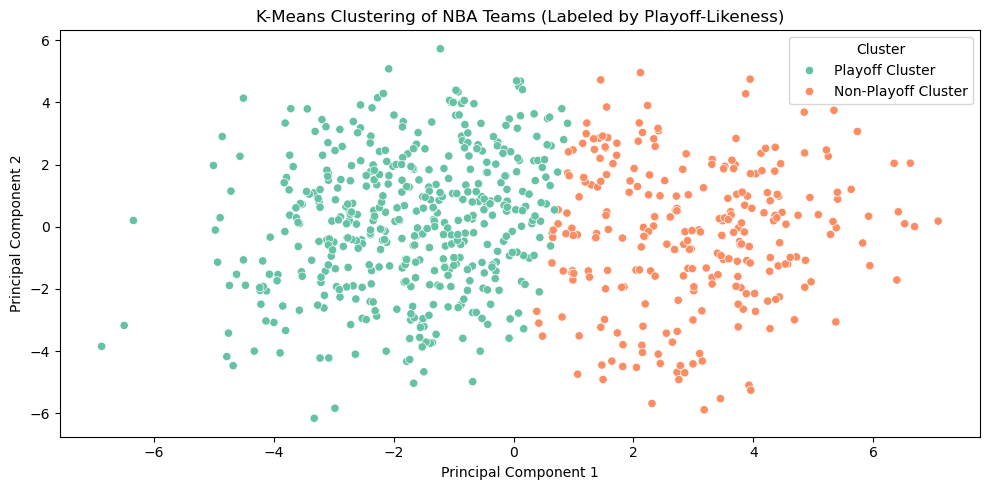

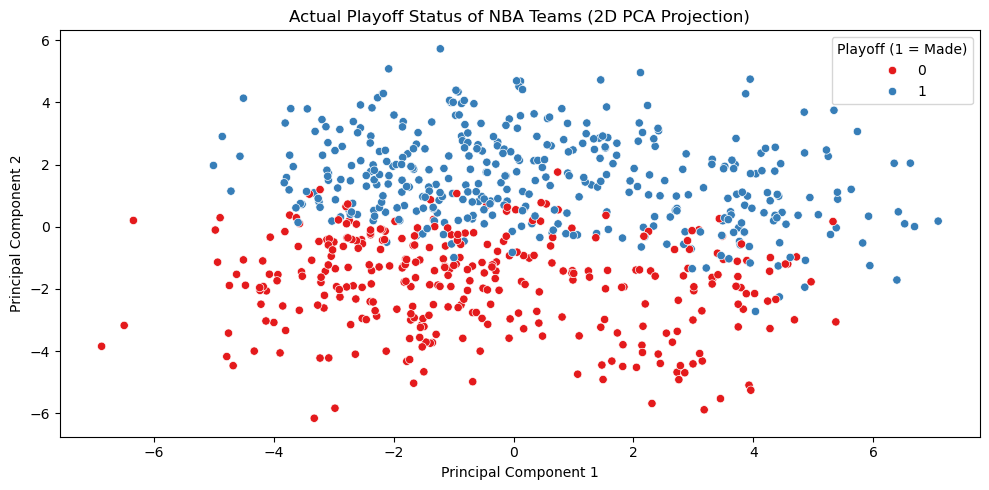

In [31]:
# Rebuild X and y to ensure clean features
exclude_cols = ['Team', 'Arena', 'W', 'L', 'WinPct', 'Year', 'Playoff', 'PW', 'PL', 'Rk']
X = df.drop(columns=[col for col in exclude_cols if col in df.columns]).dropna()
y = df.loc[X.index, 'Playoff'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for visualization
cluster_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Cluster': clusters,
    'Playoff': y
})

# Determine which cluster is playoff-heavy
cross_tab = pd.crosstab(cluster_df['Cluster'], cluster_df['Playoff'])
playoff_cluster = cross_tab[1].idxmax()

# Label clusters
cluster_df['Cluster_Label'] = cluster_df['Cluster'].apply(
    lambda x: 'Playoff Cluster' if x == playoff_cluster else 'Non-Playoff Cluster'
)

# Plot by labeled cluster
plt.figure(figsize=(10, 5))
sns.scatterplot(data=cluster_df, x='PCA1', y='PCA2', hue='Cluster_Label', palette='Set2')
plt.title("K-Means Clustering of NBA Teams (Labeled by Playoff-Likeness)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Plot actual playoff status
plt.figure(figsize=(10, 5))
sns.scatterplot(data=cluster_df, x='PCA1', y='PCA2', hue='Playoff', palette='Set1')
plt.title("Actual Playoff Status of NBA Teams (2D PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Playoff (1 = Made)")
plt.tight_layout()
plt.show()

### Step 7: Conclusion

Over the course of this analysis, we explored whether regular-season team statistics could be used to predict playoff success — and how different modeling techniques and unsupervised learning strategies can be applied to this problem.

---

### Key Findings

- **Correlation Analysis** showed that certain stats — like Net Rating (NetRtg), Point Differential, and Opponent Turnover Rate — have strong relationships with playoff qualification.
- **Logistic Regression** proved effective in classifying playoff vs. non-playoff teams:
  - Our **manual gradient ascent model** achieved ~93% accuracy, showing a solid grasp of logistic regression fundamentals.
  - The **scikit-learn model** performed similarly (~92%), validating the effectiveness of our manual implementation.
- **Top Influential Features** revealed that both offensive and defensive efficiency metrics were major drivers of playoff success.
- **Clustering via K-Means + PCA** showed that teams tend to naturally group into performance tiers:
  - One cluster captured the majority of playoff teams.
  - Even without using labels, unsupervised learning surfaced meaningful structure in the data.

---

### Limitations

- We used data from the **entire regular season**, so these models could not be used for real-time prediction.
- The labels (`Playoff`) were binary, but playoff outcomes exist on a spectrum (e.g., 1st seed vs. 8th seed).

---

### Future Work

- Explore **multi-class classification** to predict how far a team goes (e.g., first round, finals).
- Test these models using **early-season or mid-season stats** to simulate real-world playoff predictions.
- Tune hyperparameters (e.g., learning rate, regularization) for better generalization performance.

---

### Final Thoughts

This project demonstrated how basic and advanced analytics techniques — when combined with real-world sports data — can uncover meaningful insights, make reliable predictions, and build your intuition for how machine learning models interpret and interact with data.
